# Implementing Monte Carlo Strategies in Scientific Computing (Liu 2001)

####        _by Daniel Cunha_

In [3]:
import math
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 2.2 The Rejection Method (includes 2.1 Generating Simple Random Variables)

We have a target distribution $\pi(x)$ that we would like to sample. We know the density , however we do not have an analytic solution of the CDF, and thus cannot use the inversion method to sample.  Suppose we do have a distribution we can already sample, then as long as this distribution _covers_ $\pi(x)$, we can use this initial distribution, and the rejection method to sample $\pi(x)$. 

Suppose $l(x) = c\pi(x)$ is computable, where $\pi$ is a probability density, and $c$ is unknown.  If we can find a sampling distribution $g(x)$ and _covering constant_ $M$, having $Mg(x) \geq c\pi(x)\ \forall x$ Then we can apply the following procedure.

#### _Rejection Sampling_ [von Neumann(1951)]

a.) Draw a sample $x$ from $g()$ and compute the ratio $$ r = \frac{l(x)}{Mg(X)}\ (\leq1).$$
b.) Flip a coin with success probability $r$;
   * if the head turns up, we accept and return the $x$;
   * otherwise, we reject the $x$ and go back to a.)

## Example: _Truncated Gaussian Sampler_

### Setup

Suppose we want to draw samples from $$\pi(x) \propto \phi(x)I_{x>c}$$ where $\phi(x)$ is the standard normal density, $I$ is the indicator function indicating $x>c$ (note this is a new instantiation of the variable c. It is not the normalizing constant defined above).

Notice the following relationship, $$\pi(x) \propto \phi(x)I_{x>c}=\phi(x|x>c)=\frac{P(x,x>c)}{P(x>c)}= \frac{\phi(x+c)}{1-\Phi(c)}$$

Finally, let $g(x) = \lambda_0 e^{-\lambda_0 x}$.  We can sample this distribution by analytically inverting its CDF.

#### Define needed functions

In [4]:
#This is the _err_ function needed for the Gaussian distribution CDF
def err(x,n):
    err_x = 0
    for i in range(n):
        err_x += ((-1.0)**i) * (x**((2.0*i)+1))/(math.factorial(i)*((2*i)+1))
    err_x = (2.0/math.sqrt(math.pi))*err_x
    return err_x

In [5]:
#Approximation to Gaussian Distribution CDF
def Phi(x,n):
    return 0.5*(1.0+err((x/math.sqrt(2.0)),n))

In [6]:
#Inverve of Exponential CDF with parameter lambda_0
def inverse_exp(x,lambda_0):
    return -1.0*math.log(1.0-x)/float(lambda_0)

In [7]:
#Exponential density
def expo(x,lambda_0):
    return lambda_0*math.exp(-lambda_0*x)

In [8]:
#Gaussian density
def phi(x):
    return math.exp((-(x**2.0))/2.0)/math.sqrt(2.0*math.pi)

#### Set up assumptions and kwargs

In [9]:
#We will draw samples from phi(x)*I_{x>c}
c = 0.0

In [10]:
#Numerical precision of the err function in the Gaussian CDF; degree of taylor polynomial approximation
n = 125

In [11]:
#Gaussian CDF evaluated at c
Phi_c = Phi(c,n)

### Optimize the envelope function and comparison distribution

#### Here's how to solve for $b$
Let $b$ be a constant chosen to ensure $b*g(x)$ is an _envelope_ of $l(x)$. The variable $b$ is an instance of the variable $M$ used in the introductory discussion. 

Choose $b$ such that the following inequality to hold for $\forall x$:

\begin{align*}
    \frac{\phi(x+c)}{1-\Phi(c)} \leq b\lambda_0e^{-\lambda_0x}\tag{Setup}\\
    \frac{e^{\frac{-(x+c)^2}{2}}e^{\lambda_0x}}{\sqrt{2\pi}(1-\Phi(c))\lambda_0} \leq b\tag{Replace $\phi$ with standard normal, solve for b}
\end{align*}

Now choose the maximum value of the left side w.r.t. $x$ by setting the derivative of its $log$ to $0$
\begin{align*}
    -(x+c)+\lambda_0 = 0\tag{After taking derivative}\\
    x = \lambda_0 - c
\end{align*}

Finally, plug this value of $x$ back into the original equation to get $b$
$$b = \frac{e^\frac{\lambda_0^2 - 2\lambda c}{2}}{\sqrt{2\pi}(1-\Phi(c))\lambda_0}$$

#### Here's how to solve for $\lambda$

We have solved $b$ such that $\forall x$
$$\frac{\phi(x+c)}{1-\Phi(c)} \leq b\lambda_0e^{-\lambda_0x}$$
The rejection rate of this sampler of $\pi(x)$ is  $\frac{1}{b}$. The next step is to choose the parameter $\lambda_0$ to minimize the rejection rate.  Set $\frac{d\ log(\frac{1}{b})}{d \lambda_0}=0$ and solve for $\lambda_0$.
$$\lambda_0 = \frac{c + \sqrt{c^2 + 4}}{2}$$

In [13]:
lambda_0 = (c + math.sqrt((c**2.0)+4.0))/2.0

In [14]:
b = math.exp(((lambda_0**2.0) - (2.0*lambda_0*c))/2.0)/(math.sqrt(2.0*math.pi)*lambda_0*(1.0-Phi_c))

### Run the rejection sampler
Now run the rejection sampler as defined in the introduction of this notebook

In [16]:
def truncated_gaussian_sampler(itera):
    exponential = []
    samples = []
    rejection = []
    probabilities = []
    for i in range(itera):
        x_inv = np.random.uniform()
        x = inverse_exp(x_inv, lambda_0)
        r = (phi(x+c)/(1-Phi_c))/(b*expo(x,lambda_0))
        probabilities.append(r)
        exponential.append(x)
        coin = np.random.uniform()
        if coin<r:
            #print("keep sample")
            samples.append(x)
            rejection.append(0)
        else:
            #print("reject sample")
            rejection.append(1)
    return np.array(samples),np.array(rejection),np.array(exponential),np.array(probabilities)

In [17]:
itera=100000
samples,rejection,exponential,probabilities = truncated_gaussian_sampler(itera)

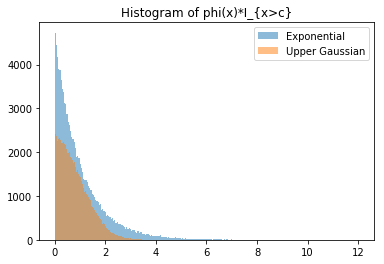

In [18]:
plt.hist(exponential, bins='auto', alpha=0.5,label='Exponential')
plt.hist(samples, bins='auto', alpha=0.5,label='Upper Gaussian')  # arguments are passed to np.histogram
plt.legend(loc='upper right')
plt.title("Histogram of phi(x)*I_{x>c}")
plt.show()

In [19]:
samples.mean(), samples.var()

(0.7954301053959651, 0.36364251806673153)

In [21]:
#The empirical rejection rate matches the analytical result
rejection.mean(), 1-(1/b)

(0.23966, 0.23982654946685966)

In [22]:
#The inversion method correctly samples from the exponential distribution
lambda_0**(-1), exponential.mean(),

(1.0, 0.9969463767723395)

In [23]:
lambda_0**(-2), exponential.var()

(1.0, 0.9981890980232558)